# Variational AutoEncoder in Keras

## Keras

* Python 2.7-3.6
* Simple and high level
* Various backends (TensorFlow, CNTK, Theano)
* Not as flexible or quite as fast as other toolkits like PyTorch

## Installation

Installing keras with tensorflow backend using conda is very easy

* https://www.anaconda.com/blog/developer-blog/tensorflow-in-anaconda/
* CPU:
  * `conda create -n tf_cpu tensorflow`
* GPU
  * `conda create -n tf_gpu tensorflow-gpu`
  * NVIDIA driver for your system has to be installed separately

#### Additional Setup

* Some packages
```bash
conda install jupyter matplotlib pydot graphviz numpy
```

* Register with base jupyter environment
```bash
conda activate tf_gpu
python -m ipykernel install --prefix=/home/chris/local/miniconda3 --name 'python-tf_gpu'
```

# Tutorial 

Largely derived from the Keras documentation, especially https://blog.keras.io/building-autoencoders-in-keras.html

## Setup

Start notebook with:

```bash
conda activate tf_gpu
jupyter notebook
```

In [1]:
# Import some libraries
import tensorflow
# Keras can also be installed as its own package.
import tensorflow.keras as keras

import matplotlib.pyplot as plt
import numpy as np

## Getting the MNIST data

* Getting standard datasets is easy with keras!
* Ignore the labels, as we're doing self-supervised learning

In [7]:
from tensorflow.keras.datasets import mnist

(x_train_2d, _), (x_test_2d, _) = mnist.load_data()

x_train_2d = x_train_2d.astype('float32')/255.0
x_test_2d = x_test_2d.astype('float32')/255.0

## What do the input images look like?

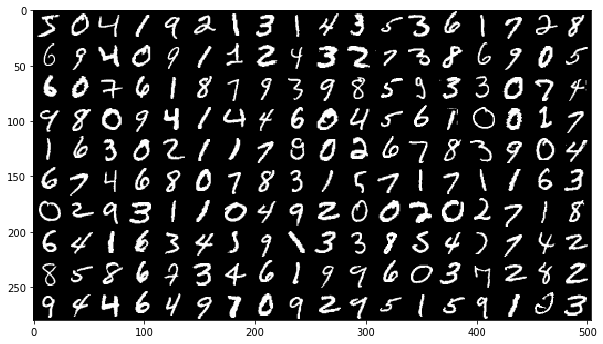

In [8]:
Nx,Ny=28,28

Mx,My=18,10
img = np.zeros((Ny*My,Nx*Mx), dtype=float)
for i in range(Mx):
    for j in range(My):
        img[Ny*j:Ny*(j+1), Nx*i:Nx*(i+1)] = x_train_2d[j*Mx+i, :, :]
plt.figure(figsize=(My,Mx))
plt.imshow(img, cmap="gray", interpolation="nearest")
#plt.imshow(np.reshape(x_train[0:9,:,:], (Nx*9, Ny)), cmap="gray", interpolation="nearest")

# Simple two layer Autoencoder

## Define the model

In [18]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


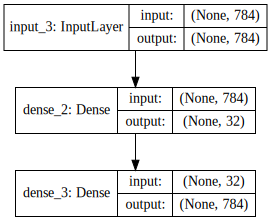

In [19]:
# Graphical summary of the model

from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
def show_model(model, *args, **kwargs):
    return SVG(model_to_dot(model, *args, **kwargs).create(prog='dot', format='svg'))

show_model(autoencoder, show_shapes=True)

## Attach optimizer and loss function

In [20]:
# Cross entropy loss
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# MSE: Simpler and faster, but less sensible
# autoencoder.compile(optimizer='adadelta', loss='mse')

## Reshape training data

In [21]:
from tensorflow.keras.datasets import mnist

(x_train_2d, _), (x_test_2d, _) = mnist.load_data()
x_train_2d = x_train_2d.astype('float32')/255.0
x_test_2d = x_test_2d.astype('float32')/255.0

x_train = x_train_2d.reshape((len(x_train_2d), np.prod(x_train_2d.shape[1:])))
x_test = x_test_2d.reshape((len(x_test_2d), np.prod(x_test_2d.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## Train Model

In [22]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.3581 - val_loss: 0.2711
Epoch 2/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.2633 - val_loss: 0.2514
Epoch 3/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.2401 - val_loss: 0.2269
Epoch 4/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.2194 - val_loss: 0.2098
Epoch 5/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.2051 - val_loss: 0.1981
Epoch 6/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1948 - val_loss: 0.1890
Epoch 7/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.1867 - val_loss: 0.1818
Epoch 8/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1799 - val_loss: 0.1753
Epoch 9/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1740 - val_loss: 0.1699
Epoch

## How well did we do?

We can pull the model apart into a separate encoder and decoder

In [23]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

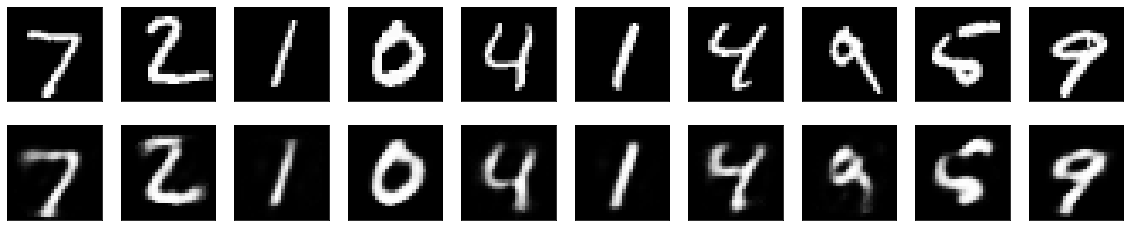

In [24]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


---

# Convolutional example

---

## Define the model

In [43]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape
from tensorflow.keras.models import Model

input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
#autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.compile(optimizer='adadelta', loss='mse')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 4, 4, 8)           0         
__________

In [44]:
#show_model(autoencoder, show_shapes=True)

## Prepare training data

In [45]:
from tensorflow.keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
x_train.shape

(60000, 28, 28, 1)

## Train model

This time we'll look at progress in TensorBoard - start it in the console with the following
```bash
tensorboard --logdir=/tmp/autoencoder
```

Then go to <http://localhost:6006>

In [46]:
from tensorflow.keras.callbacks import TensorBoard
import os.path

run_name = "run1"
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir=os.path.join('/tmp/autoencoder', run_name))])


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 87us/step - loss: 6.1281 - val_loss: 3.7706
Epoch 2/20
60000/60000 [==============================] - 5s 82us/step - loss: 3.5614 - val_loss: 2.8443
Epoch 3/20
60000/60000 [==============================] - 5s 80us/step - loss: 2.9267 - val_loss: 2.5187
Epoch 4/20
60000/60000 [==============================] - 5s 80us/step - loss: 2.6395 - val_loss: 2.2937
Epoch 5/20
60000/60000 [==============================] - 5s 80us/step - loss: 2.4602 - val_loss: 2.1634
Epoch 6/20
60000/60000 [==============================] - 5s 78us/step - loss: 2.3401 - val_loss: 2.0861
Epoch 7/20
60000/60000 [==============================] - 5s 82us/step - loss: 2.2436 - val_loss: 1.9850
Epoch 8/20
60000/60000 [==============================] - 5s 81us/step - loss: 2.1794 - val_loss: 1.9589
Epoch 9/20
60000/60000 [==============================] - 5s 86us/step - loss: 2.1252 - val_loss: 1.8986
Epoch

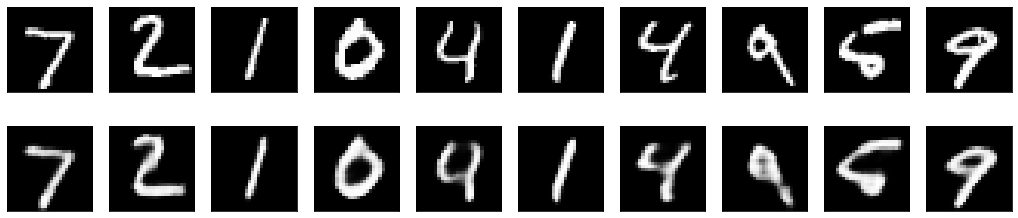

In [47]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(18, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


---

# Convolutional variational autoencoder

---

Derived from the keras example

https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder_deconv.py

In [48]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Lambda
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

In [49]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [52]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 30

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 14, 14, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 7, 7, 64)     18496       conv2d_44[0][0]                  
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_45[0][0]                  
__________________________________________________________________________________________________
dense_6 (D

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 69076     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         65089     
Total params: 134,165
Trainable params: 134,165
Non-trainable params: 0
_________________________________________________________________


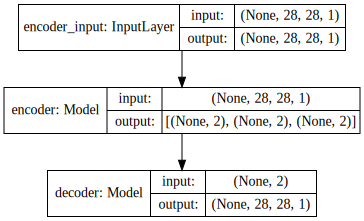

In [53]:
models = (encoder, decoder)
data = (x_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss
if True:
    reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
else:
    reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                              K.flatten(outputs))

reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()
show_model(vae, show_shapes=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 12s 193us/step - loss: 50.2186 - val_loss: 44.2702
Epoch 2/30
60000/60000 [==============================] - 11s 181us/step - loss: 43.7049 - val_loss: 42.5304
Epoch 3/30
60000/60000 [==============================] - 11s 180us/step - loss: 42.4599 - val_loss: 41.7539
Epoch 4/30
60000/60000 [==============================] - 11s 177us/step - loss: 41.5292 - val_loss: 40.9893
Epoch 5/30
60000/60000 [==============================] - 11s 175us/step - loss: 40.6967 - val_loss: 41.0129
Epoch 6/30
60000/60000 [==============================] - 11s 177us/step - loss: 40.1102 - val_loss: 40.2835
Epoch 7/30
60000/60000 [==============================] - 10s 175us/step - loss: 39.6484 - val_loss: 39.3956
Epoch 8/30
60000/60000 [==============================] - 10s 173us/step - loss: 39.3110 - val_loss: 40.0911
Epoch 9/30
60000/60000 [==============================] - 11s 179us/step - los

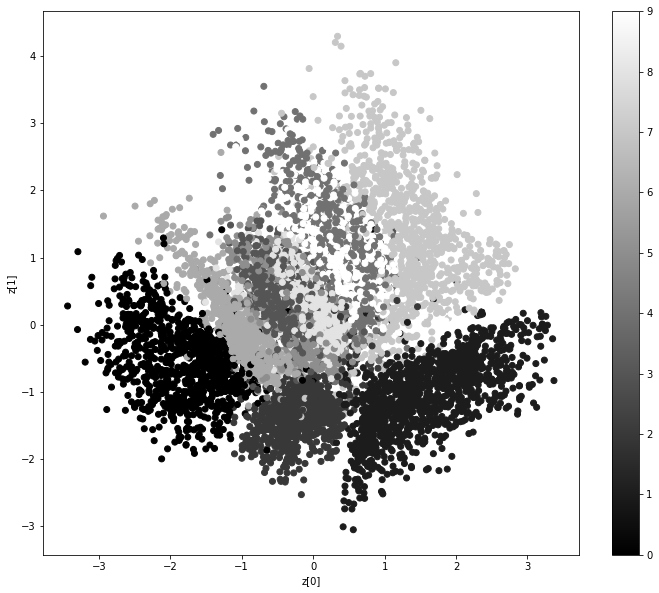

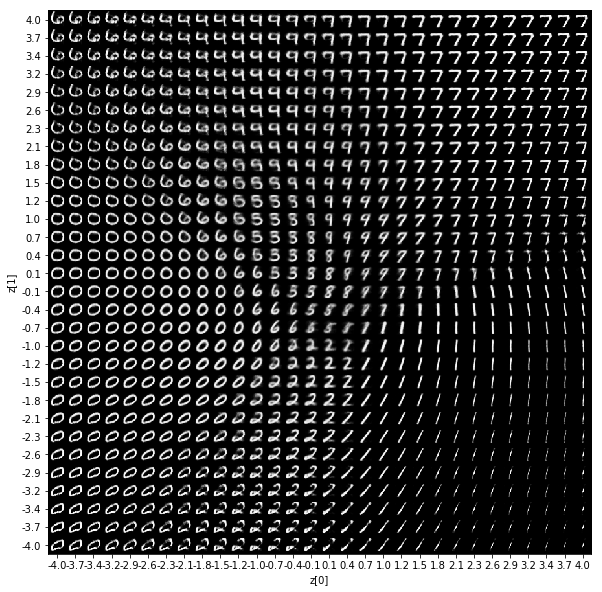

In [54]:
# vae.load_weights(args.weights)

vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

#vae.save_weights('vae_cnn_mnist.h5')

plot_results(models, data, batch_size=batch_size, model_name="vae_cnn")